# NER with Evolutionary Algorithms


- Take example of conll 2002 &check;
- Transform example to Doument object
  - Create vocabulary from corpus text
  - Create vocabulary from corpus iob
  - Create vocabulary from file &check;
  - Create vocabulary from spacy
  - Create vocabulary from conll2002 &check;
  - Create vocabulary from spacy after preprocessing
- Transform Document object to array &check;
- Create text documents to WORD POS DEPREL
  - Train neural network with word lemma pos deprel to predict next token
- Generate rules using genetic algorithm
  - Generate init population
    - Create chromosome
    - Select next token:
      - Get transition data
      - Filter samples evaluating their quality
  - Create fitness function
    - Evaluate fitness function
  - Create mutation function
    - Change token
    - Change transition
  - Create crossover function
    - Change token
    - Change transition
  - Evaluate population
    - Evaluate fitness
    - Select best samples
- Join rules
  - Support vector machine


## Config


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load Glove model from zip file
# from gensim.models  import  KeyedVectors

# glove_model = KeyedVectors.load_word2vec_format("glove-sbwc.i25.vec.gz", binary=False)


In [2]:
from typing import List,TYPE_CHECKING,Iterable,Dict,Optional
import numpy as np

In [4]:
# from evolution_rules import cpp_perfomance_by_doc, cpp_fitness_by_individual, cpp_fitness, cosine_similarity


In [3]:
import torch
from transformers import AutoModel, AutoTokenizer

In [4]:
model_path = "symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli"
cache_dir = "/home/jraba/Dev/cache-ml-models"
tokenizer = AutoTokenizer.from_pretrained(model_path, cache_dir=cache_dir)
model_ml = AutoModel.from_pretrained(model_path, cache_dir=cache_dir)

In [5]:
from functools import lru_cache
import torch.nn.functional as F

embedding_size = 32

@lru_cache(maxsize=1000)
def get_ml_embedding(sentence: str) -> torch.Tensor:
    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        # First element of model_output contains all token embeddings
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    encoded_input = tokenizer(
        sentence,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=8,
    )
    # Compute token embeddings
    with torch.no_grad():
        model_output = model_ml(**encoded_input)
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    # Normalize embeddings
    # sentence_embeddings = F.normalize(
    #     sentence_embeddings.reshape(embedding_size, -1).mean(axis=1).expand(1, -1),
    #     p=2,
    #     dim=1,
    # )
    sentence_embeddings = sentence_embeddings.reshape(embedding_size, -1).mean(axis=1).expand(1, -1)
    return sentence_embeddings[0]


@lru_cache(maxsize=1000)
def similarity(sentence1: str, sentence2: str) -> float:
    vector1 = get_ml_embedding(sentence1)
    vector2 = get_ml_embedding(sentence2)
    return (vector1 @ vector2).sum() / (vector1.norm() * vector2.norm())

In [6]:
similarity("Hoon", "hoon")

tensor(0.9238)

In [7]:
similarity("DET", "ROOT")

tensor(0.2040)

In [8]:
def get_ml_embeddings(sentence: List[str]) -> torch.Tensor:
    return torch.stack([get_ml_embedding(s) for s in sentence])

In [9]:
from ga_ner import linguistic_features as lf
num_docs = 10

## Transform data


In [10]:
from ga_ner.models import Vocabulary

enconding = "iso-8859-1"
vocab = Vocabulary.from_iob("data/train/esp.train.txt", enconding, num_docs)

In [10]:
vocab.to_file("data/vocabs/conn-2002-uncased-vocab.txt")

### Evolutinary NER Rules


1. Take a example of conll 2002
2. Create Ner rule with samples using genetic algorithm
3. Label data with rules
4. Train neural network with data labeled with rules
5. Select samples with high precision
6. repeat steps 2-5 with selected samples until precision is high enough


In [29]:
import numpy as np
from ga_ner.models import GANER, Document, Corpus, Vocabulary
import spacy
from spacy.tokens import DocBin

if TYPE_CHECKING:
    from spacy.tokens import Doc as SpacyDoc

### 1. Take a example of conll 2002

1. Load conll2002 to spacy documents
2. Load Vocabulary from conll2002
3. Take random samples from spacy documents
4. Convert Spacy models to Corpus object from samples


##### 1. Load conll2002 to spacy models


In [23]:
nlp = spacy.load("es_dep_news_trf", exclude=["ner"])

In [24]:
# Load spacy documents
from spacy.training.converters import conll_ner_to_docs

conll_file = "data/train/esp.train.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs = conll_ner_to_docs(input_data, n_sents=1, no_print=False, model="es_dep_news_trf")

In [40]:
# Simple load
spacy_ner_doc = list(docs)

In [ ]:
# Add to spacy_ner_doc pos and dep tags

for d in nlp.pipe(spacy_ner_doc, disable=["tok2vec", "tagger", "attribute_ruler"]):
    print([(t.text, t.pos_, t.dep_) for t in d])

In [36]:
# Save to disk
doc_bin = DocBin(
    docs=nlp.pipe(
        spacy_ner_doc, 
        disable=["tok2vec", "tagger", "attribute_ruler"])
    )
doc_bin.to_disk("./data/ner_ea.spacy")

In [38]:
# load from disk
# Load the DocBin from the file
doc_bin_loaded = DocBin().from_disk("./data/ner_ea.spacy")

# Get the list of Spacy Docs from the DocBin
docs_loaded = list(doc_bin_loaded.get_docs(nlp.vocab))

# Print the text of each Spacy Doc
for doc in docs_loaded[:5]:
    for token in doc:
        print(f"{token.text:{15}} {token.pos_:{10}} {token.dep_:{10}} {token.ent_type_:{10}}")

Melbourne       PROPN      ROOT       LOC       
(               PUNCT      punct                
Australia       PROPN      flat       LOC       
)               PUNCT      punct                
,               PUNCT      punct                
25              NUM        nummod               
may             NOUN       appos                
(               PUNCT      punct                
EFE             PROPN      flat       ORG       
)               PUNCT      punct                
.               PUNCT      punct                
-               PUNCT      ROOT                 
El              DET        det                  
Abogado         PROPN      nsubj      PER       
General         PROPN      flat       PER       
del             ADP        case       PER       
Estado          PROPN      flat       PER       
,               PUNCT      punct                
Daryl           PROPN      flat       PER       
Williams        PROPN      flat       PER       
,               PUNC

In [41]:
# Load spacy documents
from spacy.training.converters import conll_ner_to_docs

conll_file = "data/test/esp.testa.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs = conll_ner_to_docs(input_data, n_sents=1, no_print=False, model="es_dep_news_trf")

In [42]:
# Simple load
spacy_ner_doc = list(docs)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [44]:
# Save to disk
doc_bin = DocBin(
    docs=nlp.pipe(
        spacy_ner_doc, 
        disable=["tok2vec", "tagger", "attribute_ruler"])
    )
doc_bin.to_disk("./data/validation.spacy")

In [45]:
# load from disk
# Load the DocBin from the file
doc_bin_loaded = DocBin().from_disk("./data/validation.spacy")

# Get the list of Spacy Docs from the DocBin
docs_loaded = list(doc_bin_loaded.get_docs(nlp.vocab))

# Print the text of each Spacy Doc
for doc in docs_loaded[:5]:
    for token in doc:
        print(f"{token.text:{15}} {token.pos_:{10}} {token.dep_:{10}} {token.ent_type_:{10}}")

Sao             PROPN      ROOT       LOC       
Paulo           PROPN      flat       LOC       
(               PUNCT      punct                
Brasil          PROPN      flat       LOC       
)               PUNCT      punct                
,               PUNCT      punct                
23              NUM        nummod               
may             NOUN       appos                
(               PUNCT      punct                
EFECOM          PROPN      flat       ORG       
)               PUNCT      punct                
.               PUNCT      punct                
-               PUNCT      ROOT                 
La              DET        det                  
multinacional   NOUN       nsubj                
española        ADJ        amod                 
Telefónica      PROPN      appos      ORG       
ha              AUX        aux                  
impuesto        VERB       ccomp                
un              DET        det                  
récord          NOUN

In [46]:
# Load spacy documents
from spacy.training.converters import conll_ner_to_docs

conll_file = "data/test/esp.testb.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs = conll_ner_to_docs(input_data, n_sents=1, no_print=False, model="es_dep_news_trf")

In [47]:
# Simple load
spacy_ner_doc = list(docs)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [48]:
# Save to disk
doc_bin = DocBin(
    docs=nlp.pipe(
        spacy_ner_doc, 
        disable=["tok2vec", "tagger", "attribute_ruler"])
    )
doc_bin.to_disk("./data/test.spacy")

In [49]:
# load from disk
# Load the DocBin from the file
doc_bin_loaded = DocBin().from_disk("./data/test.spacy")

# Get the list of Spacy Docs from the DocBin
docs_loaded = list(doc_bin_loaded.get_docs(nlp.vocab))

# Print the text of each Spacy Doc
for doc in docs_loaded[:5]:
    for token in doc:
        print(f"{token.text:{15}} {token.pos_:{10}} {token.dep_:{10}} {token.ent_type_:{10}}")

La              DET        det        LOC       
Coruña          PROPN      ROOT       LOC       
,               PUNCT      punct                
23              NUM        appos                
may             NOUN       dep                  
(               PUNCT      punct                
EFECOM          PROPN      appos      ORG       
)               PUNCT      punct                
.               PUNCT      punct                
-               PUNCT      ROOT                 
Las             DET        det                  
reservas        NOUN       nsubj                
"               PUNCT      punct                
on              ADJ        amod                 
line            ADJ        amod                 
"               PUNCT      punct                
de              ADP        case                 
billetes        NOUN       nmod                 
aéreos          ADJ        amod                 
a               ADP        case                 
través          NOUN

In [26]:
samples_len = len(spacy_ner_doc)
samples_len

8323

##### 2. Load Vocabulary from conll2002


In [27]:
vocabulary = Vocabulary.from_file(
    "data/vocabs/conn-2002-uncased-vocab.txt", include_special=False
)

2784 = Vocab

62 = Dep

19 = POS

2703 = Word


##### 3. Take random samples from spacy documents


In [17]:
sample_is_complete_1 = np.zeros(samples_len, dtype=bool)

In [18]:
np.random.seed(42)
selected_indices = np.random.choice(samples_len, size=samples_len, replace=False)
# selected_indices_1 = selected_indices[:10]

In [19]:
samples_len

8323

In [20]:
#  Select index based in entity type
# Count number of entities by type
from collections import Counter

entity_counter = Counter()

for doc in spacy_ner_doc:
    for ent in doc.ents:
        entity_counter[ent.label_] += 1

# Normalize
total_entities = sum(entity_counter.values())
for k in entity_counter:
    entity_counter[k] = entity_counter[k] / total_entities

# Select indices
# Add index if entity type is less proporcional
# Selected indices remove
# Do until all entity types are selected
selected_indexes_stratified = []
was_selected = np.zeros(samples_len, dtype=bool)
entity_selected_counter = Counter()
while not was_selected.all():
    for i in selected_indices:
        doc = spacy_ner_doc[i]
        if not was_selected[i]:
            if len(doc.ents)==0:
                was_selected[i] = True
                continue
            total_selected = sum(entity_selected_counter.values())
            if total_selected==0 or entity_selected_counter[doc.ents[0].label_]/total_selected < entity_counter[doc.ents[0].label_]:
                selected_indexes_stratified.append(i)
                for ent in doc.ents:
                    was_selected[i] = True
                    entity_selected_counter[ent.label_] += 1

In [21]:
entity_counter

Counter({'LOC': 0.26141078838174275,
         'ORG': 0.39312692839663793,
         'PER': 0.2298648792424726,
         'MISC': 0.11559740397914672})

In [22]:
selected_indices_1 = selected_indexes_stratified[:10]
selected_indices_1

[7000, 1346, 5204, 4952, 7423, 4509, 7468, 533, 4619, 1385]

##### 4. Convert Spacy models to Corpus object


In [23]:
def sample_spacy_docs(
    docs: List["SpacyDoc"],
    selected_indices: Iterable[int],
    sample_is_complete: Iterable[int],
) -> Iterable["SpacyDoc"]:
    """
    Sample a list of spacy documents of selected index.
    If doc is not complete, it will be completed in spacy pipeline.
    """
    spacy_models = [
        docs[index] for index in selected_indices if not sample_is_complete[index]
    ]

    # Complement spacy documents
    spacy_models = list(
        nlp.pipe(spacy_models, disable=["tok2vec", "tagger", "attribute_ruler"])
    )

    # Reassign spacy document
    index_doc = 0
    for index in selected_indices:
        if not sample_is_complete[index]:
            spacy_models[index_doc] = spacy_ner_doc[index]
            sample_is_complete[index] = True
            index_doc += 1
        yield docs[index]

In [24]:
corpus_1 = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc, selected_indices_1, sample_is_complete_1),
    total_samples=len(selected_indices_1),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    emb_size=embedding_size,
)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [30]:
spacy_docs = list(
    sample_spacy_docs(spacy_ner_doc, selected_indices_1, sample_is_complete_1)
)

In [36]:
# # spaCy docs to conll
# from spacy.training import offsets_to_biluo_tags
# from tqdm.auto import tqdm as tdqm

# results = []
# for doc in tdqm(spacy_ner_doc):
#     # Preliminary: whole sentence
#     whole_sentence = doc.text
#     # 1st item (CoNLL 2003): word
#     words = [token.text for token in doc]
#     # 2nd item (CoNLL 2003): POS
#     pos = [token.pos_ for token in doc]
#     # 3rd item (CoNLL 2003): syntactic dependency
#     dep = [token.dep_ for token in doc]
#     # 4th item (CoNLL 2003): named entities
#     spacy_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
#     biluo_entities = offsets_to_biluo_tags(doc, spacy_entities)
#     results.append((whole_sentence, words, pos, dep, biluo_entities))

# # write to file
# with open("data/train/esp.train.conll", "w", encoding="utf-8") as f:
#     for result in tdqm(results):
#         # print("-DOCSTART- -X- -X- O")
#         if result[0].strip() == "-":
#             f.write("-DOCSTART- -X- -X- O\n")
#         else:
#             for w, x, y, z in zip(result[1], result[2], result[3], result[4]):
#                 f.write(f"{w} {x} {y} {z}\n")
#         f.write("\n")


In [37]:
# spacy_ner_doc[0]._.conll_str

In [32]:
vocab_ent = Vocabulary.from_list(list(corpus_1.entities.keys()), include_special=False)

In [33]:
corpus_1.documents[0].unk_id

tensor([-0.0702, -0.0671,  0.0422,  0.0751, -0.0545, -0.0136, -0.0125,  0.0699,
         0.0931,  0.0150, -0.1770, -0.0753,  0.1406, -0.0690,  0.0584,  0.0122,
         0.0424, -0.0066, -0.0469,  0.2698, -0.0530, -0.1566, -0.1648,  0.0829,
         0.0109, -0.0457, -0.1312, -0.0837,  0.0892, -0.1082,  0.0966, -0.0172])

In [53]:
corpus_1.to_text_array(
    input_filename="input.txt",
    target_filename="target.txt",
    metadata_filename="metadata.txt",
)

### 2. Create Ner rule with samples using genetic algorithm

1. From corpus create datasets by entities to predict
   - From datasets:
     - Convert to array
     - Get representation of documents for entities to predict
1. To Train Genetic Algorithm for entity
1. Get best genetic ner rules


**Candidate Words**: are the words that can be used activate a new gene in the rule, that word are taken from words that create the entity to predict.

In [ ]:
def create_candidate_words(
        corpus:Corpus, 
        candidate_words: Optional[np.ndarray] = None, 
        save_path: str = None):
    """
    Create candidate words from corpus
    :param corpus_1: corpus_1
    :param candidate_words: candidate words
    :param save_path: save path
    :return: candidate words
    """
    if candidate_words is None:
        candidate_words = np.empty((0, 2))
    for document in corpus.documents:
        for entity in document.entities:
            for index_entiy in range(entity.start, entity.end):
                for index_feature in range(3):
                    candidate_words = np.vstack(
                        (
                            candidate_words,
                            np.append(
                                index_feature,
                                document.tokens[index_entiy][index_feature].value,
                            ),
                        )
                    )
    if save_path:
        np.savetxt(save_path, candidate_words, fmt="%s", delimiter=",")
    return candidate_words

In [49]:
# A candidate word is a index feature + embedding
candidate_words = np.zeros((0, embedding_size + 1), dtype=np.float32)
for document in corpus_1.documents:
    for entity in document.entities:
        for index_entiy in range(entity.start, entity.end):
            for index_feature in range(3):
                candidate_words = np.vstack(
                    (
                        candidate_words,
                        np.append(
                            index_feature,
                            document.tokens[index_entiy][index_feature].value,
                        ),
                    )
                )

In [50]:
print(candidate_words.shape)
# write to file
with open("data/train/esp.train.candidate_words", "w", encoding="utf-8") as f:
    for candidate_word in candidate_words:
        f.write(",".join([str(x) for x in candidate_word]))
        f.write(f"\n")

(171, 33)


**Parent Population** are created using entities in training corpus. Use diferent lenfth of entities. For First loop create tuples with length equal 1 for each feature of token then create 3 individuals (3x1). For second loop create tuples with length equals 2 for each feature and combinate posibilities, then create 18 individual (3²x2), repetead until complete the length parent population.

##### 1. From corpus create datasets by entities to predict


### Structure


Each individual has next structure:

    - first token is size of rule or number of segments will be used
    - second is fitness value
    - third is entity type to predict
    - next tokens are segments of rule

Each segment has next structure:

    - first token indicate if a entity is predicted
    - second token is value for linguistic feature type
    - next tokens are embedding values for linguistic feature value

An individual has 7 seven segments. To indicate that there is an entity is used value 1 else 0. The segments that are not used are filled with 0. Size of segment is 2 + embedding size.

## Example:

An individual which size is 3, fitness value is 0.5, entity type is PER, and has 3 segments wich embedding size is 2.
The first segment is for word feature and has value "John" and embedding [0.1, 0.2].
The second segment is for pos feature and has value "NOUN" and embedding [0.4, 0.5].
The third segment is for dep feature and has value "aux" and embedding [0.7, 0.8].
The 2 fisrt segments are indicators for entity prediction.

| 3.0 | 0.5 | 1.0 | 1.0 | 0.0 | 0.1 | 0.2 | 1.0 | 1.0 | 0.4 | 0.5 | 0.0 | 2.0 | 0.7 | 0.8 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |

Size of individual is 3 + 7 \* (2 + 2) = 31


In [25]:
# Load candidate words
candidate_words = np.loadtxt(
    "data/train/esp.train.candidate_words", delimiter=",", dtype=np.float32
)

In [26]:
entity_names = []
with open("entity_names.txt", "r") as file:
    for line in file:
        entity_names.append(line.strip())

In [27]:
entity_map = np.array(["O"] + entity_names)
entity_map

array(['O', 'PER', 'MISC', 'ORG', 'LOC'], dtype='<U4')

In [28]:
entity_map_inv = {entity: index for index, entity in enumerate(entity_map)}
entity_map_inv

{'O': 0, 'PER': 1, 'MISC': 2, 'ORG': 3, 'LOC': 4}

In [29]:
from itertools import product

len(list(product(range(3), range(3), range(3), range(3))))

81

In [30]:
list(product(range(3), range(3), range(3)))

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [40]:
for document in corpus_1.documents:
    for entity in document.entities:
        print(entity)

Entity(label=ORG, name=Lucchetti, start=5, end=6)
Entity(label=ORG, name=Grupo Luksic, start=10, end=12)
Entity(label=LOC, name=Argentina, start=33, end=34)
Entity(label=LOC, name=Perú, start=35, end=36)
Entity(label=LOC, name=Chile, start=37, end=38)
Entity(label=MISC, name=Educación, Cultura. Deportes, start=10, end=13)
Entity(label=PER, name=Pilar del Castillo, start=14, end=17)
Entity(label=PER, name=Bonet, start=23, end=24)
Entity(label=ORG, name=Consejo de Ministros, start=25, end=28)
Entity(label=MISC, name=Oferta Pública de Suscripción, start=20, end=24)
Entity(label=MISC, name=OPS, start=25, end=26)
Entity(label=ORG, name=Federación Nacional de Industrias Lácteas, start=4, end=9)
Entity(label=ORG, name=FENIL, start=10, end=11)
Entity(label=PER, name=Pedro Ara, start=13, end=15)
Entity(label=ORG, name=Inlac, start=31, end=32)
Entity(label=LOC, name=Ohmhajer, start=21, end=22)
Entity(label=ORG, name=Etiopía, start=31, end=32)
Entity(label=ORG, name=Eritrea, start=39, end=40)
Ent

In [40]:
from tqdm.auto import tqdm, trange
import random

entity_dataset: Dict[str, Dict[str, np.ndarray]] = {}
max_size_doc = 172
s_init_pop = 400
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)
# First 3 columns are for size, fitness and entity
parent_population = np.zeros((s_init_pop, max_len), dtype=np.float32)
# Size = 1
parent_population[:, 0] = 1
# Entity = 1 for first 100 samples
parent_population[:100, 2] = 1
# Entity = 2 for next 100 samples
parent_population[100:200, 2] = 2
# Entity = 3 for next 100 samples
parent_population[200:300, 2] = 3
# Entity = 4 for next 100 samples
parent_population[300:400, 2] = 4

random.seed(42)

# add entities to parent population
for individual_index, individual in enumerate(parent_population):
    candidate_index = random.randint(0, len(candidate_words) - 1)
    # Add 1 to indicate that it's a entity
    parent_population[individual_index][3 : 3 + embedding_size + 2] = np.concatenate(
        ([1], candidate_words[candidate_index])
    )

In [41]:
corpus_1.documents[0].entities

[Entity(label=ORG, name=Lucchetti, start=5, end=6),
 Entity(label=ORG, name=Grupo Luksic, start=10, end=12),
 Entity(label=LOC, name=Argentina, start=33, end=34),
 Entity(label=LOC, name=Perú, start=35, end=36),
 Entity(label=LOC, name=Chile, start=37, end=38)]

In [41]:
from tqdm.auto import tqdm, trange
import random

entity_dataset: Dict[str, Dict[str, np.ndarray]] = {}
max_size_doc = 172
s_init_pop = 400
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)
# First 3 columns are for size, fitness and entity
parent_population = np.zeros((s_init_pop, max_len), dtype=np.float32)

# Initialize population
cur_ind_len = 1
cur_pop_len = 0
fishished = False
any_entity = True
previous_start = 0
while not fishished and any_entity:
    any_entity = False
    for document in tqdm(corpus_1.documents):
        for entity in document.entities:
            fishished = fishished or cur_pop_len >= s_init_pop
            if entity.end - entity.start - previous_start >= cur_ind_len  and not fishished and entity.start - previous_start > 0:
                any_entity = True
                feature_values = []
                for index_feature in range(entity.start-previous_start, entity.start+cur_ind_len):
                    feature_values.append(range(3))

                for combination_value in product(*feature_values):
                    parent_population[cur_pop_len, 0] = cur_ind_len
                    parent_population[cur_pop_len, 1] = 0
                    parent_population[cur_pop_len, 2] = entity_map_inv[entity.label]
                    for index_combination, index_feature in enumerate(combination_value):
                        start_index = 3 + index_combination * (embedding_size + 2)
                        end_index = start_index + (embedding_size + 2)
                        index_token = entity.start + index_combination - previous_start
                        entity_id = entity_map_inv[entity.label] if index_token >= entity.start else 0
                        parent_population[cur_pop_len][start_index] = entity_id
                        parent_population[cur_pop_len][start_index+1] = index_feature
                        parent_population[cur_pop_len][start_index+2:end_index] = document.tokens[index_token][index_feature].value
                    cur_pop_len += 1

                    if cur_pop_len >= s_init_pop:
                        fishished = True
                        break
    cur_ind_len += 1
    if not any_entity and cur_pop_len < s_init_pop:
        any_entity = True
        cur_ind_len = 1
        previous_start += 1




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from itertools import product

In [42]:
# Get index where embedding is in
embedding_list = []
for index in range(3, max_len, embedding_size + 2):
    print(index+2, index+embedding_size+2)
    embedding_list.extend(range(index+2, index+embedding_size+2))

5 37
39 71
73 105
107 139
141 173
175 207
209 241


In [43]:
(max_len-3)/34

7.0

In [ ]:
def read_inpu_txt(input_filename, target_filename, metadata_filename, num_docs, max_size_doc, embedding_size):
    doc_dataset = np.zeros((num_docs, max_size_doc * embedding_size * 3), dtype=np.float32)
    target_doc = np.zeros((num_docs, max_size_doc), dtype=np.int32)
    metadata_doc = np.zeros((num_docs, 4), dtype=np.int32)
    with open(input_filename) as input_file, open(target_filename) as target_file, open(
    metadata_filename
    ) as metadata_file:
        for doc_index, line in enumerate(input_file):
            input_doc = np.array([float(x) for x in line.split(",")], dtype=np.float32)
            doc_dataset[doc_index, : input_doc.shape[0]] = input_doc
        for doc_index, line in enumerate(target_file):
            line_target = np.array([int(x) for x in line.split(",")])
            target_doc[doc_index, : line_target.shape[0]] = line_target
        for doc_index, line in enumerate(metadata_file):
            line_metadata = np.array([int(x) for x in line.split(",")])
            metadata_doc[doc_index, : line_metadata.shape[0]] = line_metadata
    return doc_dataset, target_doc, metadata_doc

In [44]:
# Init doc dataset with initial file
# Transform to document spacy to numpy array
import numpy as np

doc_dataset = np.zeros((num_docs, max_size_doc * embedding_size * 3), dtype=np.float32)
target_doc = np.zeros((num_docs, max_size_doc), dtype=np.int32)
metadata_doc = np.zeros((num_docs, 4), dtype=np.int32)
# TODO Function to read from file
with open("input.txt") as input_file, open("target.txt") as target_file, open(
    "metadata.txt"
) as metadata_file:
    for doc_index, line in enumerate(input_file):
        input_doc = np.array([float(x) for x in line.split(",")], dtype=np.float32)
        doc_dataset[doc_index, : input_doc.shape[0]] = input_doc
    for doc_index, line in enumerate(target_file):
        line_target = np.array([int(x) for x in line.split(",")])
        target_doc[doc_index, : line_target.shape[0]] = line_target
    for doc_index, line in enumerate(metadata_file):
        line_metadata = np.array([int(x) for x in line.split(",")])
        metadata_doc[doc_index, : line_metadata.shape[0]] = line_metadata

assert doc_dataset.shape == (num_docs, max_size_doc * embedding_size * 3)
assert target_doc.shape == (num_docs, max_size_doc)
assert metadata_doc.shape == (num_docs, 4)

In [45]:
metadata_doc

array([[ 46,   5, 100,   4],
       [ 34,   4, 100,   4],
       [ 34,   2, 100,   4],
       [ 46,   4, 100,   4],
       [ 41,   3, 100,   4],
       [  8,   2, 100,   4],
       [ 46,   1, 100,   4],
       [ 49,   4, 100,   4],
       [ 29,   1, 100,   4],
       [ 39,   3, 100,   4]], dtype=int32)

##### 2. To Train Genetic Algorithm for entity


<p style="text-align: center;">Individual fitness</p>

$$f_i=\frac{TP_i}{TP_i+FP_i} * \log_2(TP_i+FP_i)$$

<p style="text-align: center;">Sharing function</p>

$$
sh(d_{i,j}) = \left \{
    \begin{array}{l}
    1  - \frac{d_{i,j}}{\sigma_{share}}, d_{i,j} < {\sigma_{share}}  \\
    0, otherwise
    \end{array}
\right \}
$$

<p style="text-align: center;">Individual shared fitness</p>

$$f^t_i = \frac{f_i}{\sum_{j=1}^N sh(d_{i,j})}$$


$$
  \text{fitness}(\text{ind}, \text{doc}) = \begin{cases}
    -1.0                                                                                                                                                                                                 & \text{if } \text{retrive\_doc} = 0 \\
    0.8 \times \text{Precision} + 0.1 \times \frac{\log_2(\text{ind size})}{\log_2(7)} + 0.1 \times ind\_seq & \text{otherwise}
  \end{cases}
$$

<div style="text-align: center;">

<p style="text-align: center;">Island model</p>

![image.png](./img/island_ae.svg)

</div>


In [46]:
# from pytorch_lightning.callbacks import ModelCheckpoint
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# import pytorch_lightning as pl
# from ga_ner.ml.models import TransformerModel
# from ga_ner.ml.loss import accuracy_loss


# checkpoint_callback = ModelCheckpoint(
#     "./checkpoints_p", save_weights_only=True, monitor="val_loss", mode="min"
# )

# trainer = pl.Trainer(callbacks=[checkpoint_callback], enable_progress_bar=False)
# model = TransformerModel.load_from_checkpoint("checkpoints/epoch=304-step=3050.ckpt")
# trainer.model = model


In [45]:
doc_dataset.shape

(10, 16512)

In [163]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary
from ga_ner.utils.numba import select, fitness

# from ga_ner.utils.numba import select
# from evolution_rules import select
ga_ner = GANER(
    map_inv_entity=None,#map_inv_entity
    n_population=400,
    max_len=max_len,
    mask_id=0,#corpus_1.documents[0].mask_id
    unknown_id=0,#corpus_1.documents[0].unk_id
    candidate_words=candidate_words,
    random_state=42,
    n_top=100,
    threshold=0.8,
    select=select,
    fitness=fitness,
    num_threads=16,
    embedding_size=embedding_size,
)
ga_ner.train(
    doc_dataset,
    target_doc,
    metadata_doc,
    max_iter=1000,
    tol=15,
    base_population=parent_population,
    num_islands=4,
    num_threads=16,
)

# 2015_Book_IntroductionToEvolutionaryComp.pdf 80, 108, 120, 145,294

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving 217 individuals
Saving 275 individuals
Saving 305 individuals
Saving 328 individuals
Saving 349 individuals
Saving 362 individuals
Saving 362 individuals
Saving 366 individuals
Saving 364 individuals
Saving 367 individuals
Saving 360 individuals
Saving 367 individuals
Saving 368 individuals
Saving 369 individuals
Saving 366 individuals
Saving 367 individuals
Saving 366 individuals
Saving 365 individuals
Saving 366 individuals
Saving 370 individuals
Saving 369 individuals
Saving 364 individuals
Saving 366 individuals
Saving 362 individuals
Saving 368 individuals
Saving 366 individuals
Saving 364 individuals
Saving 360 individuals
Saving 355 individuals
Saving 359 individuals
Saving 357 individuals
Saving 362 individuals
Saving 357 individuals
Saving 363 individuals
Saving 368 individuals
Saving 364 individuals
Saving 362 individuals
Saving 368 individuals
Saving 368 individuals


In [110]:
# Save entity names of ga_entities in file
with open("entity_names.txt", "w") as file:
    for entity in ga_ner.data.keys():
        file.write(entity)
        file.write("\n")


AttributeError: 'GANER' object has no attribute 'data'

In [49]:
for ent in ga_ner.data.keys():
    print(corpus_1.documents[0].vocab_ent[ent], ent)

AttributeError: 'GANER' object has no attribute 'data'

### Test Genetic Algorithm

In [49]:
num_val = 100

In [31]:
array_rules = np.load(f"best_population.npy")
array_fitness = np.load(f"best_fitness.npy")
fitness_: np.ndarray = array_fitness

#### Transform data


In [32]:
import re

def clean_text(text):
    """Transform text to lowercase and remove punctuationand extra whitespace."""
    # text = text.lower()
    text = re.sub(r" +", " ", text)
    return text

In [41]:
# Retrieve words from embedding
with open("data/vocabs/conn-2002-uncased-vocab.txt", "r", encoding="utf-8") as iob_file:
    # POS TAGS
    word_list = list(lf.pos_tags.keys())
    # DEP TAGS
    word_list.extend(lf.dep_tags.keys())
    word_list.extend([clean_text(x.strip()) for x in iob_file.readlines()])
    # Remove duplicates
    word_list = list(set(word_list))
    # Save words_list to file
    np.save("data/vocabs/word_list.npy", word_list)

In [42]:
word_embeddings = get_ml_embeddings(word_list)
# word_embeddings to file
np.save("word_embeddings.npy", word_embeddings)

In [43]:
word_list = np.load("data/vocabs/word_list.npy")
word_embeddings = np.load("word_embeddings.npy")

In [44]:
index_rules = np.arange(array_rules.shape[0])

In [45]:
# Retrieve values from array
#  A rule is list of patterns
rules: List = []
for rule in array_rules:
    size_rule = int(rule[0])
    # A pattern is a list tuples (word, entity)
    pattern: List = []
    for i in range(size_rule):
        # Use cosine similarity to get the most similar word in the embedding
        start_index = 3 + i * (embedding_size + 2) + 2
        word_embedding = rule[start_index : start_index + embedding_size]
        similarities = np.dot(word_embeddings, word_embedding)/(np.linalg.norm(word_embeddings, axis=1) * np.linalg.norm(word_embedding))
        most_similar_word = word_list[np.argmax(similarities)]
        pattern.append((most_similar_word, int(rule[start_index - 2])))
    rules.append(pattern)

In [46]:
rules

[[('conj', 2)],
 [('flat', 1)],
 [('Rulfo', 1)],
 [('acusó', 1)],
 [('Congreso', 1)],
 [('diputados', 1)],
 [('grupo', 1)],
 [('consejo', 1)],
 [('argentino', 2)],
 [('Perú', 2)],
 [('licencias', 3)],
 [('oferta', 3)],
 [('pública', 3)],
 [('Arias', 4)],
 [('Areces', 4)],
 [('Pilar', 4)],
 [('Gijón', 4)],
 [('nmod', 1), ('acusó', 1)],
 [('del', 1), ('ni', 2)],
 [('diputados', 1), ('sobre', 1)],
 [('ministros', 1), ('PROPN', 1)],
 [('case', 2), ('argentino', 2)],
 [('Pilar', 2), ('case', 4)],
 [('Efe', 2), ('Perú', 2)],
 [('obl', 3), ('pública', 2)],
 [('licencias', 3), ('de', 3)],
 [('grupo', 3), ('consejo', 1)],
 [('sobre', 4), ('Bonet', 4)],
 [('del', 4), ('appos', 4)],
 [('appos', 4), ('ADP', 0)],
 [('flat', 1), ('ADP', 0)],
 [('case', 1), ('diputados', 1)],
 [('nsubj', 0), ('flat', 1)],
 [('obj', 0), ('diputados', 1)],
 [('flat', 0), ('flat', 1)],
 [('flat', 0), ('flat', 4)],
 [('nmod', 0), ('flat', 1)],
 [('Arias', 0), ('flat', 4)],
 [('Arias', 0), ('Areces', 4)],
 [('cultura', 0)

In [47]:
rules[-1]

[('DET', 0),
 ('obl', 3),
 ('flat', 3),
 ('licencias', 3),
 ('flat', 3),
 ('Alava', 3),
 ('PROPN', 3)]

In [48]:
pos_embeddings = get_ml_embedding("PROPN")

In [49]:
similarities = np.dot(word_embeddings, pos_embeddings)/(np.linalg.norm(word_embeddings, axis=1) * np.linalg.norm(pos_embeddings))
most_similar_word = word_list[np.argmax(similarities)]
most_similar_word

'PROPN'

##### 3. Ner using genetic rules


In [65]:
# Get list of features of population by entity type
# Use a document base to convert array to Feature using global index
from ga_ner.models import Feature, Rule, Document, Vocabulary
import numpy as np
from typing import List, Dict, Tuple, Iterable

In [66]:
vocabulary = Vocabulary.from_file(
    "data/vocabs/conn-2002-uncased-vocab.txt", include_special=False
)

vocab_ent = Vocabulary.from_list(entity_names, include_special=False)

document = Document.from_text("", vocab=vocabulary, vocab_ent=vocab_ent)

In [59]:
from ga_ner.models import Feature, Rule, Document, Vocabulary


def get_features(
    ga_pupulation: np.ndarray,
    array_fitness: np.ndarray,
    document: Document,
) -> List[Rule]:
    """
    Decode Ga rules to Rule object.
    """
    rules = []
    for index in range(ga_pupulation.shape[0]):
        # firts element is the length of the rule
        end_rule = int(ga_pupulation[index, 0]) + 3
        entity_type = corpus_1.vocab_ent[ga_pupulation[index, 2]]
        rules.append(
            document.rule_from_array(
                ga_pupulation[index, 3:end_rule],
                int(ga_pupulation[index, 2]),
                array_fitness[index],
            )
        )
    return rules


In [24]:
# Read rules from file
rules = np.zeros((0, 10), dtype=np.float32)
with open("data/rules/mpi/population_8.txt", "r") as file:
    for line in file:
        rules = np.vstack((rules, np.array(line.strip().split(" ")).astype(np.float32)))
rules = np.unique(rules, axis=0)


In [67]:
vocab_ent.inverse()[1]

'PER'

In [29]:
# fitness_ = cpp_fitness(
#     rules,
#     entity_dataset["ALL"]["input"],
#     entity_dataset["ALL"]["target"][:, :, 0],
#     entity_dataset["ALL"]["meta"],
#     corpus_1.documents[0].unk_id,
#     8,
# ).base


In [60]:
## Decode rules to Rule object
obj_rules = get_features(
    rules, np.zeros(rules.shape[0]), corpus_1.documents[0]
)  # Count rules by entity type
from collections import Counter

counter_rule = Counter([rule.entity for rule in obj_rules])
print(counter_rule)
# get value the least common entity type
min_value = min(counter_rule.values())
print(min_value)

# Index of rules by entity type. Each can be at most min_value
index_rules = []
counter_balance = Counter()
for i in fitness_.argsort()[::-1]:
    if counter_balance[obj_rules[i].entity] < min_value:
        index_rules.append(i)
        counter_balance[obj_rules[i].entity] += 1


NameError: name 'get_features' is not defined

In [27]:
current_entity = 1
for i in index_rules:
    if obj_rules[i].entity == current_entity:
        print(obj_rules[i].to_dict(vocab=vocabulary, vocab_entities=vocab_ent))
        current_entity = (current_entity) % 4 + 1


NameError: name 'obj_rules' is not defined

In [67]:
from spacy.training.converters import conll_ner_to_docs

conll_file = "data/test/esp.testa.txt"
with open(conll_file, "r", encoding="iso-8859-1") as file:
    input_data = file.read()
docs_val = conll_ner_to_docs(
    input_data, n_sents=1, no_print=False, model="es_dep_news_trf"
)
# Simple load
spacy_ner_doc_val = list(docs_val)
samples_len = len(spacy_ner_doc_val)

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.


In [68]:
num_val=100
sample_is_complete_val = np.zeros(samples_len, dtype=bool)
np.random.seed(0)
selected_indices_val = np.random.choice(samples_len, size=num_val, replace=False)

In [162]:
from ga_ner.models import GANER, Document, Corpus, Vocabulary

corpus_val = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc_val, selected_indices_val, sample_is_complete_val),
    total_samples=len(selected_indices_val),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    vocab_ent=vocab_ent,
    emb_size=embedding_size,
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
corpus_val.documents[0].entities

[Entity(label=MISC, name=Geles, start=8, end=9),
 Entity(label=LOC, name=Nueva York, start=10, end=12),
 Entity(label=ORG, name=EFE, start=16, end=17)]

In [71]:
for token in spacy_ner_doc_val[selected_indices_val[0]]:
    print(token.text, token.pos_, token.dep_, token.ent_type_)

( PUNCT punct 
añade VERB ROOT 
un DET det 
cambio NOUN obj 
en ADP case 
el DET det 
equipo NOUN obl 
de ADP case 
Geles PROPN nmod MISC
) PUNCT punct 
Nueva PROPN obl LOC
York PROPN flat LOC
, PUNCT punct 
23 NUM appos 
may NOUN appos 
( PUNCT punct 
EFE PROPN flat ORG
) PUNCT punct 
. PUNCT punct 


In [72]:
corpus_val.to_text_array(
    input_filename="data/val/input.txt",
    target_filename="data/val/target.txt",
    metadata_filename="data/val/meta.txt",
)

Predict entities using genetic rules from next samples from training. Take 20% additional samples from training to test.
Select best predicted segments and it add to training corpus.

In [80]:
current_training_size = num_docs

In [83]:
index_end = current_training_size + int(current_training_size * 0.2)
corpus_test = Corpus.from_spacy_docs(
    sample_spacy_docs(spacy_ner_doc, selected_indices[current_training_size:index_end], sample_is_complete_1),
    total_samples=len(selected_indices[current_training_size:index_end]),
    vocab=vocabulary,
    embeding_func=get_ml_embedding,
    vocab_ent=vocab_ent,
    emb_size=embedding_size,
)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [82]:
current_training_size,int(current_training_size*0.2)

(10, 2)

##### Predict entities with ner rules


In [73]:
from typing import List, Dict, Tuple, Iterable


def slice_doc(
    doc: np.ndarray,
    rule: np.ndarray,
    doc_size: int,
    embedding_size: int,
    num_features: int = 3,
) -> Iterable[Tuple[int, int]]:
    """Return indices where entity is located in the document."""
    rule_size: int = int(rule[0])
    entity_mask = np.zeros(rule_size, dtype=np.int16)
    # individual_data = rule[3 : 3 + rule_size].reshape(-1, 1)
    # Fill individual data, ignore first 2 elements for each segment
    # TODO convert to function
    individual_data = np.zeros(rule_size * embedding_size, dtype=np.float32)
    feature_array = np.zeros(rule_size, dtype=np.int32)
    for index in range(rule_size):
        start_index = index * (embedding_size + 2) + 2 + 3
        end_index = start_index + embedding_size
        individual_data[index * embedding_size : (index + 1) * embedding_size] = rule[
            start_index:end_index
        ]
        feature_array[index] = rule[start_index-1]
    # Set mask of entity
    for index in range(rule_size):
        entity_mask[index] = rule[index * (embedding_size + 2) + 3]

    similarity_threshold: float = 0.8
    for index in range(0, doc_size - rule_size + 2):
        start_index = index * embedding_size * num_features
        end_index = (index + rule_size) * embedding_size * num_features
        sliced_doc = np.zeros(rule_size * embedding_size, dtype=np.float32)
        for index_feature in range(feature_array.shape[0]):
            feature = feature_array[index_feature].item()
            displacement = feature * embedding_size
            segment_start = index_feature * embedding_size
            index_segment_doc = (
                start_index + displacement + index_feature * embedding_size * num_features
            )
            if end_index < index_segment_doc + embedding_size:
                raise ValueError("Index out of range")
            sliced_doc[segment_start : segment_start + embedding_size] = doc[
                index_segment_doc : index_segment_doc + embedding_size
            ]

        # assert sliced_doc.shape == (rule_size * embedding_size, num_features)

        index_doc = index + 1
        # Cosine similarity
        similarity: np.ndarray = sliced_doc @ individual_data
        similarity /= np.linalg.norm(sliced_doc) * np.linalg.norm(
            individual_data
        )

        if (similarity > 1+1e-6).any():
            raise ValueError("Similarity greater than 1")
        if (similarity > similarity_threshold).any():
            for index_rule in range(rule_size):
                start_index = index_doc + index_rule
                end_index = start_index + 1
                yield start_index, end_index, entity_mask[index_rule].item()
            # if rule_size == 1:
            #     yield index_doc, index_doc + 1
            # else:
            #     start_index = index_doc
            #     end_index = index_doc + 1
            #     for index_include in range(rule_size - 1):
            #         if (
            #             index_include == rule_size - 2
            #             and entity_mask[index_include + 1] > 0
            #         ):
            #             end_index = index_doc + index_include + 2
            #             if not entity_mask[index_include] > 0:
            #                 start_index = index_doc + index_include + 1
            #             yield start_index, end_index
            #         elif not entity_mask[index_include] > 0:
            #             start_index = index_doc + index_include + 1
            #         elif not entity_mask[index_include + 1] > 0:
            #             end_index = index_doc + index_include + 1
            #             yield start_index, end_index
            #             start_index = index_doc + index_include + 1
            #         elif index_include == rule_size - 2:
            #             end_index = index_doc + index_include + 2
            #             yield start_index, end_index
            #         else:
            #             end_index = index_doc + index_include + 1


In [74]:
# plot confusion matrix normalized
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def print_cm(target, predict, labels, normalize=True):
    cm = confusion_matrix(target, predict, labels=labels)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt=".2f", cmap="Blues")


In [168]:
from tqdm.auto import tqdm, trange

target = []
predict = []
num_tags = len(entity_names) + 1
input_data_all = np.array([])

# load validation data from file
max_size_doc = 172
s_init_pop = 400
gen_size = 7
max_len = 3 + gen_size * (embedding_size + 2)
val_doc_dataset = np.zeros(
    (num_val, max_size_doc * embedding_size * 3), dtype=np.float32
)
val_target_doc = np.zeros((num_val, max_size_doc), dtype=np.int32)
val_metadata_doc = np.zeros((num_val, 4), dtype=np.int32)
with open("data/val/input.txt", "r") as val_input_file, open(
    "data/val/target.txt"
) as val_target_file, open("data/val/meta.txt") as val_metadata_file:
    for doc_index, line in enumerate(val_input_file):
        input_doc = np.array([float(x) for x in line.split(",")], dtype=np.float32)
        val_doc_dataset[doc_index, : input_doc.shape[0]] = input_doc
    for doc_index, line in enumerate(val_target_file):
        line_target = np.array([int(x) for x in line.split(",")])
        val_target_doc[doc_index, : line_target.shape[0]] = line_target
    for doc_index, line in enumerate(val_metadata_file):
        line_metadata = np.array([int(x) for x in line.split(",")])
        val_metadata_doc[doc_index, : line_metadata.shape[0]] = line_metadata

In [169]:

def get_all_targets(val_doc_dataset, val_target_doc, val_metadata_doc):
    target_data_all = np.array([], dtype=int)
    for index_doc in trange(val_doc_dataset.shape[0]):
        if val_target_doc[index_doc].sum() == 0:
            continue
        doc_size = val_metadata_doc[index_doc, 0].item()
        target_data = val_target_doc[index_doc][1:doc_size+1]
        # get rules for each entity
        target.extend(entity_map[target_data].tolist())
        # get votes from rules
        target_data_all = np.concatenate((target_data_all, target_data))

    return target_data_all


def majority_vote(val_doc_dataset, val_target_doc, val_metadata_doc):
    votes_all = np.array([], dtype=int)
    doc_len_list = []
    fitness_active = np.zeros((len(index_rules),), dtype=bool)

    for index_doc, array_doc in enumerate(tqdm(val_doc_dataset)):
        if val_target_doc[index_doc].sum() == 0:
            continue

        input_data = np.zeros((gen_size * embedding_size, len(array_rules)), dtype=float)
        doc_size = val_metadata_doc[index_doc, 0].item()
        target_data = val_target_doc[index_doc][1:doc_size+1]
        doc_len_list.append(array_doc[0])
        # get rules for each entity
        index_data = 0
        target.extend(entity_map[target_data].tolist())
        
        # get votes from rules
        votes = np.zeros((val_metadata_doc[index_doc][0], 5), dtype=float)
        for index_rule in range(array_rules.shape[0]):
            slices: Iterable[Tuple[int, int, int]] = slice_doc(
                array_doc,
                array_rules[index_rule],
                doc_size=doc_size,
                embedding_size=embedding_size,
            )
            for start, end, entity_id in slices:
                # input_data[start:end, index_data] = array_fitness[index_rule]
                # entity_id = int(array_rules[index_rule, 2])
                input_data[
                    start - 1 : end - 1, index_data
                ] = entity_id  # +log2_rules[index_rule]
                # votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + array_fitness[index_rule]
                # votes[start - 2 : end - 2, int(entity_id)] += 1
                votes[start - 2 : end - 2, int(entity_id)] += array_fitness[index_rule]
                # votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + array_rules[index_rule][2]
                fitness_active[index_rule] = True
                # total_emit += end - start
                # parcial_obs[start - 2 : end - 2] += 1

                # update rule emit prob
                # rule_emit_prob[int(entity_id), index_rule] += total_emit
                # rule_emit_prob[0, index_rule] += array_doc[0] - total_emit
                # index_data += 1

        votes_all = np.vstack((votes_all, votes)) if votes_all.size else votes

    # Predict with majority vote using the best rules
    votes_all_2 = votes_all.copy()
    predict = []
    # If column 0 is 0, fill with mean of the other columns
    # filter_zero = votes_all_2[:, 0] < array_fitness[fitness_active].mean(axis=0)
    # votes_all_2[filter_zero, 0] += votes_all_2[filter_zero, 1:].sum(axis=1) / 2
    votes_all_2[:, 0] += 1
    # votes_all_2[filter_zero, 0] = array_fitness[fitness_active].mean(axis=0)

    # If column 0 is less than 0.5, fill with 0.5
    # votes_all_2[:, 0] = np.where(votes_all_2[:, 0] > 0.5, votes_all_2[:, 0], 0.5)
    means = votes_all_2[:,:].sum(axis=1)/2
    votes_all_2[:, 0] = np.where(votes_all_2[:, 0] > means, votes_all_2[:, 0], means)
    predict = entity_map[votes_all_2.argmax(axis=1)].tolist()
    return predict, votes_all_2,  array_fitness.mean(axis=0).item()


Usar corpus text, predict and filter segments text that predition greater than fitness mean.

Use new segments to predict to retrain ner rules.

In [170]:
target_data_all = get_all_targets(val_doc_dataset, val_target_doc, val_metadata_doc)
predict, votes_all_2, fitness_mean = majority_vote(val_doc_dataset, val_target_doc, val_metadata_doc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         2
        MISC       0.00      0.00      0.00         1
           O       0.83      0.86      0.84        28
         ORG       0.00      0.00      0.00         2

    accuracy                           0.73        33
   macro avg       0.21      0.21      0.21        33
weighted avg       0.70      0.73      0.71        33



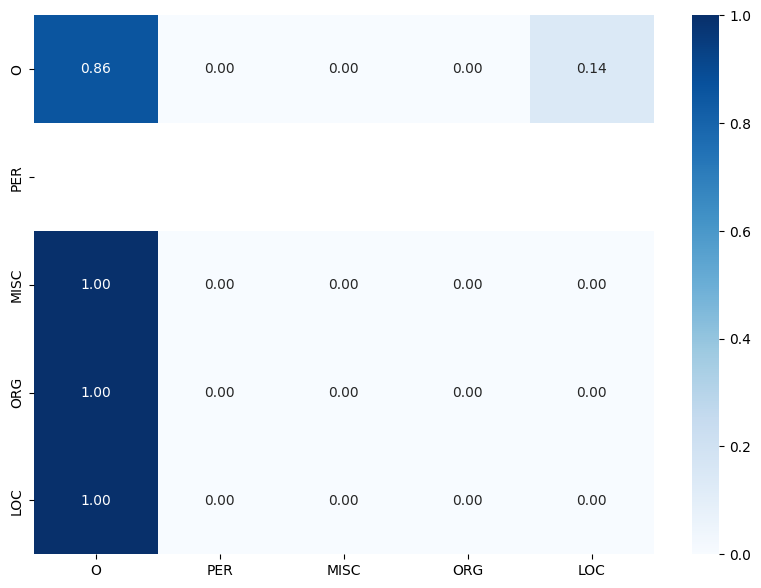

In [171]:
t = 19+14 #+51+5#+43+14+46 #2334
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

         LOC       0.02      0.02      0.02        59
        MISC       0.00      0.00      0.00        69
           O       0.90      0.96      0.93      1993
         ORG       0.25      0.02      0.04       126
         PER       0.18      0.28      0.22        87

    accuracy                           0.83      2334
   macro avg       0.27      0.25      0.24      2334
weighted avg       0.79      0.83      0.80      2334



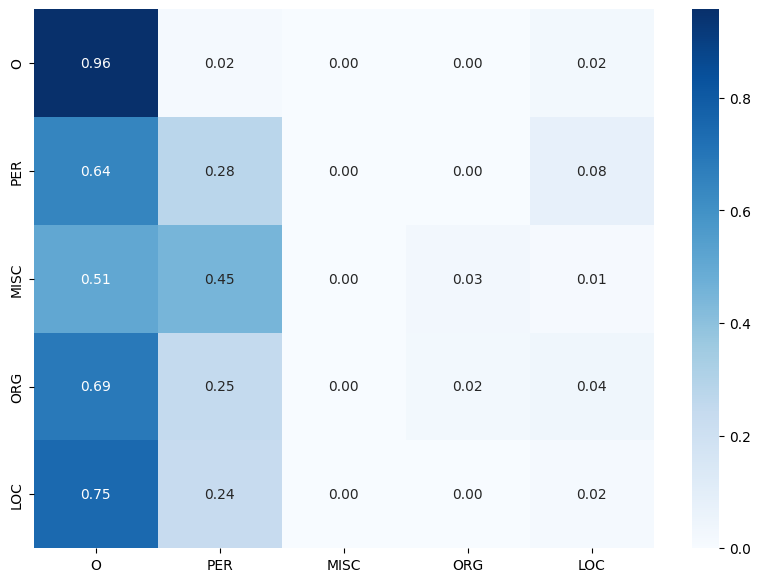

In [153]:
t = 2334# 19+14 +51+5#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

In [ ]:
#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

              precision    recall  f1-score   support

         LOC       0.01      0.02      0.01        59
        MISC       0.00      0.00      0.00        69
           O       0.89      0.87      0.88      1993
         ORG       0.19      0.05      0.08       126
         PER       0.07      0.18      0.10        87

    accuracy                           0.75      2334
   macro avg       0.23      0.22      0.21      2334
weighted avg       0.77      0.75      0.76      2334



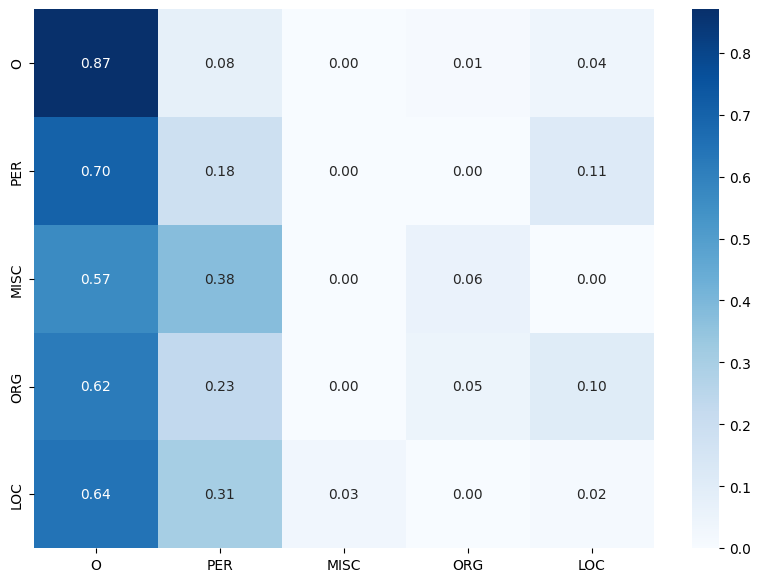

In [97]:
t = 2334# 19+14 +51+5#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

              precision    recall  f1-score   support

         LOC       0.02      0.02      0.02        59
        MISC       0.00      0.00      0.00        69
           O       0.87      0.95      0.91      1993
         ORG       0.10      0.01      0.01       126
         PER       0.10      0.09      0.09        87

    accuracy                           0.81      2334
   macro avg       0.22      0.21      0.21      2334
weighted avg       0.75      0.81      0.78      2334



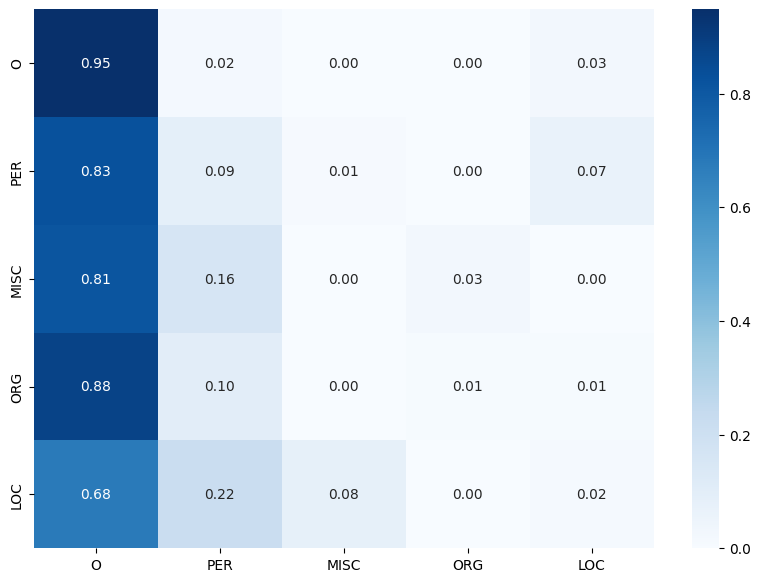

In [78]:
t = 2334# 19+14 +51+5#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

In [40]:
# add tagger to the pipeline to spacy_ner_doc
nlp2 = spacy.load("es_core_news_md", disable=["ner"])


In [41]:
index = 0
doc_spa = nlp2(str(spacy_ner_doc[index]))
doc_spa.ents = spacy_ner_doc[index].ents
doc_spa


Melbourne ( Australia ) , 25 may ( EFE ) . 

In [42]:
target = []
array_rules = rules[index_rules]
array_fitness = fitness_[index_rules]
# doc = corpus_1.documents[1]
doc = Document.from_spacy_document(doc_spa, vocabulary, vocab_ent)
array_doc = doc.to_array(exclude_label=True)
input_data = np.zeros((array_doc[0], len(array_rules)), dtype=float)
target_data = np.zeros(array_doc[0], dtype=int)
unk_id = doc.unk_id
# get rules for each entity
index_data = 0
target_data[:] = doc.to_entity_array()[2:-1]
target.extend(entity_map[doc.to_entity_array()[2:-1]].tolist())
# target_tensor[index_doc, array_doc[0]] = tag_to_ix[STOP_TAG]

# index_rules = np.argsort(np.load(f"best_fitness.npy"))[::-1]
# array_rules = np.load(f"best_population.npy")[index_rules][:200]
# array_fitness = np.load(f"best_fitness.npy")[index_rules][:200]
# get votes from rules
votes = np.zeros((array_doc[0], 5), dtype=float)
for index_rule in range(array_rules.shape[0]):
    slices = slice_doc(array_doc, array_rules[index_rule], unk_id)
    for start, end in slices:
        # input_data[start:end, index_data] = array_fitness[index_rule]
        entity_id = array_rules[index_rule, 2]
        input_data[
            start - 2 : end - 2, index_data
        ] = entity_id  # +log2_rules[index_rule]
        votes[start - 2 : end - 2, int(entity_id)] = (
            votes[start - 2 : end - 2, int(entity_id)] + array_fitness[index_rule]
        )
        # votes[start-2:end-2, int(entity_id)] = votes[start-2:end-2, int(entity_id)] + 1

    index_data += 1


In [169]:
votes[:, 0] = votes[:, 1:].sum(axis=1) / 2
votes[:, 0] = np.where(votes[:, 0] > 0.5, votes[:, 0], 0.5)
predicted_entities = entity_map[votes.argmax(axis=1)].tolist()
print(predicted_entities)
print(target)


['O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'O', 'LOC', 'LOC', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'ORG', 'O', 'ORG', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [44]:
spacy.displacy.render(doc_spa, style="ent", jupyter=True, options={"distance": 100})


In [45]:
# Define start and end each entity predicted
ex = [
    {"text": str(doc_spa), "ents": [], "title": None},
]

prev_entity = predicted_entities[0]
start = 0
end = 0
for index, entity in enumerate(predicted_entities):
    if entity != prev_entity:
        if prev_entity != "O":
            span = doc_spa[start : end + 1]
            ex[0]["ents"].append(
                {"start": span.start_char, "end": span.end_char, "label": prev_entity}
            )
        start = index
        prev_entity = entity
    end = index
if entity == prev_entity and prev_entity != "O":
    span = doc_spa[start : end + 1]
    ex[0]["ents"].append(
        {"start": span.start_char, "end": span.end_char, "label": prev_entity}
    )


# Render the entities
spacy.displacy.render(ex, style="ent", manual=True, jupyter=True)


In [46]:
# Define start and end each entity predicted
ex = [
    {"text": str(doc_spa), "ents": [], "title": None},
]
predicted_entities = entity_map[classifier.predict(input_data)].tolist()
prev_entity = predicted_entities[0]
start = 0
end = 0
for index, entity in enumerate(predicted_entities):
    if entity != prev_entity:
        if prev_entity != "O":
            span = doc_spa[start : end + 1]
            ex[0]["ents"].append(
                {"start": span.start_char, "end": span.end_char, "label": prev_entity}
            )
        start = index
        prev_entity = entity
    end = index
if entity == prev_entity and prev_entity != "O":
    span = doc_spa[start : end + 1]
    ex[0]["ents"].append(
        {"start": span.start_char, "end": span.end_char, "label": prev_entity}
    )


# Render the entities
spacy.displacy.render(ex, style="ent", manual=True, jupyter=True)


In [47]:
from pathlib import Path

spacy.displacy.render(doc_spa, style="dep", jupyter=True, options={"distance": 100})

svg = spacy.displacy.render(
    doc_spa, style="dep", jupyter=False, options={"distance": 120}
)
output_path = Path("./docs/img/sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)


3887

In [220]:
array_fitness.mean(axis=0)

1.5268041

In [262]:
# Predict with majority vote using the best rules
votes_all_2 = votes_all.copy()
predict = []
# If column 0 is 0, fill with mean of the other columns
filter_zero = votes_all_2[:, 0] < array_fitness.mean(axis=0)
# votes_all_2[filter_zero, 0] += votes_all_2[filter_zero, 1:].sum(axis=1) / 2
# votes_all_2[:, 0] += 1
votes_all_2[filter_zero, 0] = array_fitness.mean(axis=0)

# If column 0 is less than 0.5, fill with 0.5
# votes_all_2[:, 0] = np.where(votes_all_2[:, 0] > 0.5, votes_all_2[:, 0], 0.5)
means = votes_all_2[:,:].sum(axis=1)/2
votes_all_2[:, 0] = np.where(votes_all_2[:, 0] > means, votes_all_2[:, 0], means)
predict = entity_map[votes_all_2.argmax(axis=1)].tolist()
len(predict)

2334

In [263]:
((votes_all_2[:, 1] == 0) & (votes_all_2[:,2] == 0)& (votes_all_2[:,3] == 0)& (votes_all_2[:,4]> votes_all_2[:,0])).sum()

0

In [264]:
np.where([(votes_all_2[:,4]> votes_all_2[:,0])])

(array([], dtype=int64), array([], dtype=int64))

In [265]:
votes_all_2[4].shape

(5,)

              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00        59
        MISC       0.05      0.03      0.04        69
           O       0.96      0.89      0.92      1993
         ORG       0.22      0.76      0.34       126
         PER       0.00      0.00      0.00        87

    accuracy                           0.80      2334
   macro avg       0.24      0.34      0.26      2334
weighted avg       0.83      0.80      0.81      2334



/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

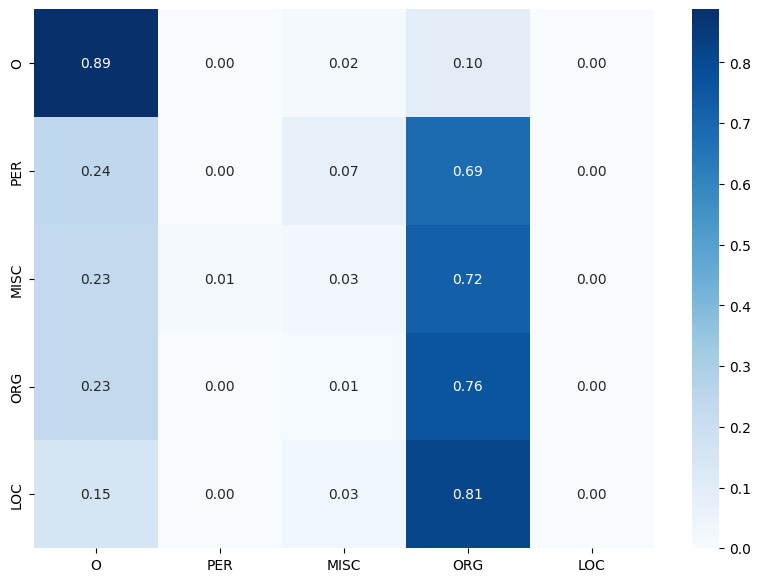

In [266]:
t = 2334# 19+14 +51+5#+43+14+46
print(classification_report(entity_map[target_data_all[:t]], predict[:t]))
print_cm(entity_map[target_data_all[:t]], predict[:t], entity_map)

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         LOC       0.26      0.39      0.31        59
        MISC       0.10      0.06      0.07        69
           O       0.97      0.99      0.98      1993
         ORG       0.55      0.43      0.48       126
         PER       0.31      0.28      0.29        87

    accuracy                           0.89      2334
   macro avg       0.44      0.43      0.43      2334
weighted avg       0.88      0.89      0.89      2334



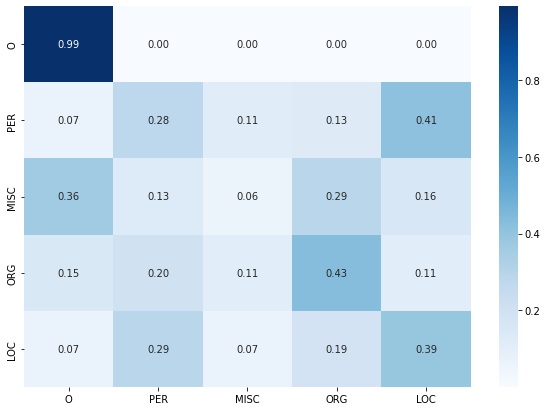

In [50]:
target = []
predict = []
votes_all_val = np.array([], dtype=float)

for doc in tqdm(corpus_val.documents[:266]):
    if len(doc.entities) == 0:
        continue

    # index_rule = fitness_.argsort()[::-1][:400]
    array_rules = rules[index_rules]
    array_doc = doc.to_array(exclude_label=True)
    input_data = np.zeros((array_doc[0], len(array_rules)), dtype=float)
    target_data = np.zeros(array_doc[0], dtype=float)
    unk_id = doc.unk_id
    # get rules for each entity
    index_data = 0
    target_data[:] = doc.to_entity_array()[2:-1]
    target.extend(entity_map[doc.to_entity_array()[2:-1]].tolist())

    # for entity_index, entity in enumerate(entity_names, 1):
    # array_rules = np.load(f"best_population.npy")
    # array_fitness = np.load(f"best_fitness.npy")

    # get votes from rules
    votes = np.zeros((array_doc[0], 5), dtype=float)
    for index_rule in range(array_rules.shape[0]):
        slices = slice_doc(array_doc, array_rules[index_rule], unk_id)
        # log2_rules = np.log10(array_rules[:, 0])
        for start, end in slices:
            entity_id = array_rules[index_rule, 2]
            input_data[start - 2 : end - 2, index_data] = entity_id
            # input_data[start:end, index_data] = array_rules[index_rule, 2]# +log2_rules[index_rule]
            votes[start - 2 : end - 2, int(array_rules[index_rule, 2])] = (
                votes[start - 2 : end - 2, int(array_rules[index_rule, 2])]
                + array_fitness[index_rule]
            )
        index_data += 1

    # extend input data all with input data
    votes_all_val = np.vstack((votes_all_val, votes)) if votes_all_val.size else votes
    predict.extend(entity_map[classifier.predict(input_data)].tolist())

print(classification_report(target, predict))
print_cm(target, predict, entity_map)


/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LOC       0.13      0.85      0.22        59
        MISC       0.03      0.01      0.02        69
           O       0.99      0.91      0.95      1993
         ORG       0.45      0.26      0.33       126
         PER       0.00      0.00      0.00        87

    accuracy                           0.81      2334
   macro avg       0.32      0.41      0.30      2334
weighted avg       0.87      0.81      0.83      2334



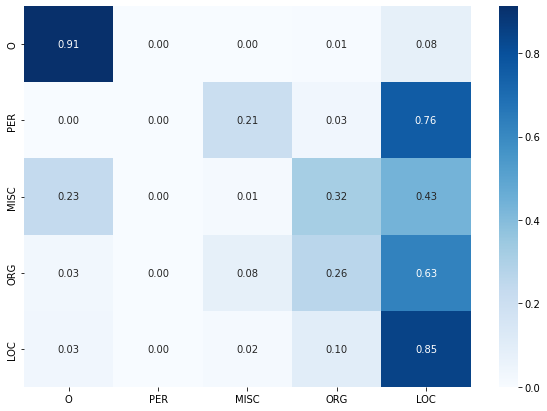

In [51]:
predict = []
votes_all[:, 0] = votes_all[:, 1:].sum(axis=1) / 2
votes_all[:, 0] = np.where(votes_all[:, 0] > 0.5, votes_all[:, 0], 0.5)
predict = entity_map[votes_all_val.argmax(axis=1)].tolist()
print(classification_report(target, predict))
print_cm(target, predict, entity_map)


[(1, 1.0), (2, 1.9151450447623743), (3, 2.5060519776903307), (4, 3.7249354066606433), (5, 4.586968827467744), (6, 4.965085200562017), (8, 5.670728764478765)]


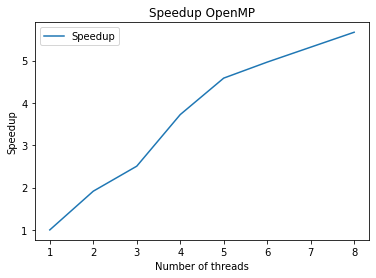

[(1, 1.0), (2, 0.9575725223811872), (3, 0.8353506592301102), (4, 0.9312338516651608), (5, 0.9173937654935488), (6, 0.8275142000936695), (8, 0.7088410955598456)]


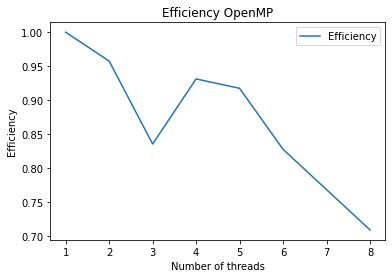

In [49]:
# Plot speedup openmp from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_opemmp = pd.read_csv("data/rules/openmp/time.txt", sep=",", header=None)
df_opemmp.columns = ["Num threads", "time"]
df_opemmp["speedup"] = df_opemmp["time"][0] / df_opemmp["time"]
df_opemmp["efficiency"] = df_opemmp["speedup"] / df_opemmp["Num threads"]
print([i for i in zip(df_opemmp["Num threads"], df_opemmp["speedup"])])
plt.plot(df_opemmp["Num threads"], df_opemmp["speedup"], label="Speedup")
plt.xlabel("Number of threads")
plt.ylabel("Speedup")
plt.title("Speedup OpenMP")
plt.legend()
plt.show()

# Plot efficiency openmp from dataframe
print([i for i in zip(df_opemmp["Num threads"], df_opemmp["efficiency"])])
plt.plot(df_opemmp["Num threads"], df_opemmp["efficiency"], label="Efficiency")
plt.xlabel("Number of threads")
plt.ylabel("Efficiency")
plt.title("Efficiency OpenMP")
plt.legend()
plt.show()


[(4096, 79.31664723086192), (2048, 34.484143834956846), (1024, 16.84999583312248), (512, 10.321562380469098), (256, 5.665460392158735), (128, 2.983193630682609), (64, 2.007584246546774)]


/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


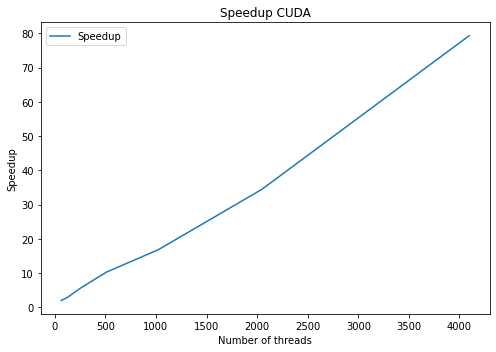

[(4096, 0.019364415827847148), (2048, 0.016837960856912523), (1024, 0.016455074055783673), (512, 0.020159301524353707), (256, 0.02213070465687006), (128, 0.02330620023970788), (64, 0.031368503852293346)]


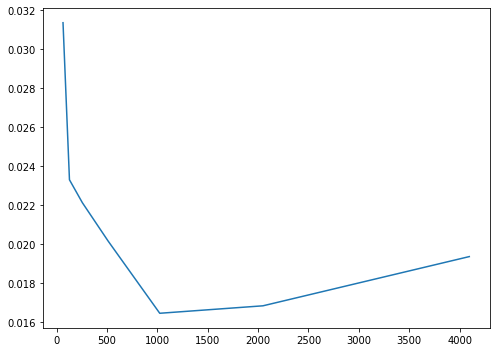

In [64]:
# Plot speedup cuda from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

plt.rcParams["figure.figsize"] = [7.00, 5.0]
# plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()

df_cuda = pd.read_csv("data/rules/cuda/time.txt", sep=",", header=None)
df_cuda.columns = ["Num threads", "time"]
df_cuda["speedup"] = df_opemmp["time"][0] / df_cuda["time"]
df_cuda["efficiency"] = df_cuda["speedup"] / df_cuda["Num threads"]
print([i for i in zip(df_cuda["Num threads"], df_cuda["speedup"])])
plt.plot(df_cuda["Num threads"], df_cuda["speedup"], label="Speedup")
plt.xlabel("Number of threads")
plt.ylabel("Speedup")
plt.title("Speedup CUDA")
plt.legend()
plt.show()
# save plot svg
plot_path = Path("docs/img/speedup_cuda.svg")
fig.savefig(plot_path, format="svg")


# Plot efficiency cuda from dataframe
print([i for i in zip(df_cuda["Num threads"], df_cuda["efficiency"])])
plt.plot(df_cuda["Num threads"], df_cuda["efficiency"], label="Efficiency")


[(1, 1.0), (2, 1.6719849982419814), (3, 2.42244933537705), (4, 3.394441712536286), (5, 4.228881186044765), (6, 4.732803998761446), (8, 5.898214733615764)]


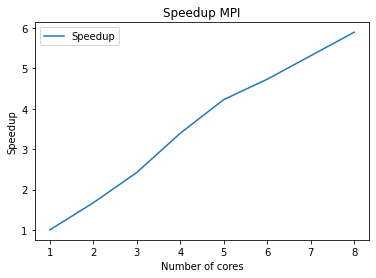

[(1, 1.0), (2, 0.8359924991209907), (3, 0.80748311179235), (4, 0.8486104281340715), (5, 0.845776237208953), (6, 0.7888006664602409), (8, 0.7372768417019705)]


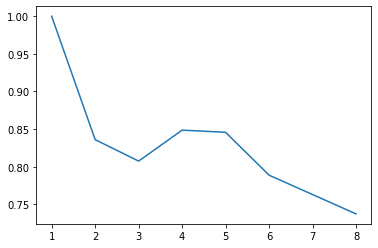

In [100]:
# Plot speedup mpi from file

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_mpi = pd.read_csv("data/rules/mpi/time.txt", sep=",", header=None)
df_mpi.columns = ["Num cores", "time"]
df_mpi["speedup"] = df_mpi["time"][0] / df_mpi["time"]
print([i for i in zip(df_mpi["Num cores"], df_mpi["speedup"])])

plt.plot(df_mpi["Num cores"], df_mpi["speedup"], label="Speedup")
plt.xlabel("Number of cores")
plt.ylabel("Speedup")
plt.title("Speedup MPI")
plt.legend()
plt.show()

# Plot efficiency mpi from dataframe
df_mpi["efficiency"] = df_mpi["speedup"] / df_mpi["Num cores"]
print([i for i in zip(df_mpi["Num cores"], df_mpi["efficiency"])])
plt.plot(df_mpi["Num cores"], df_mpi["efficiency"], label="Efficiency")


/home/jraba/Dev/gar-lener-es/env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


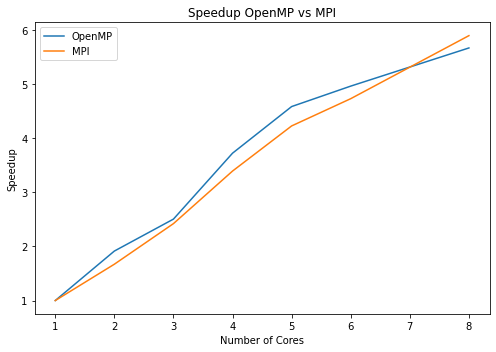

In [66]:
# Speed up openmp vs mpi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()

df_opemmp = pd.read_csv("data/rules/openmp/time.txt", sep=",", header=None)
df_opemmp.columns = ["Num Cores", "time"]
df_opemmp["opemMP"] = df_opemmp["time"][0] / df_opemmp["time"]

df_mpi = pd.read_csv("data/rules/mpi/time.txt", sep=",", header=None)
df_mpi.columns = ["Num Cores", "time"]
df_mpi["MPI"] = df_mpi["time"][0] / df_mpi["time"]

df = pd.merge(df_opemmp, df_mpi, on="Num Cores")

plt.plot(df["Num Cores"], df["opemMP"], label="OpenMP")
plt.plot(df["Num Cores"], df["MPI"], label="MPI")
plt.xlabel("Number of Cores")
plt.ylabel("Speedup")
plt.title("Speedup OpenMP vs MPI")
plt.legend()
plt.show()

# Save plot svg
plot_path = Path("docs/img/speedup_openmp_vs_mpi.svg")
fig.savefig(plot_path)


In [79]:
glove_model.similar_by_word("ok")


[('reykdæla', 0.5446478724479675),
 ('skútu', 0.5289386510848999),
 ('heiðreks', 0.5280407667160034),
 ('herrauðs', 0.5191207528114319),
 ('hólmverja', 0.510186493396759),
 ('hálfsrekka', 0.4899718463420868),
 ('honum', 0.48458901047706604),
 ('harðar', 0.4820405840873718),
 ('einhenda', 0.4651539921760559),
 ('bósa', 0.46174266934394836)]

In [78]:
glove_model.most_similar_cosmul(
    positive=["afirmar", "si", "ok"], negative=["negar"], topn=28
)


[('decir', 0.5594726204872131),
 ('ahora', 0.557867169380188),
 ('momento', 0.5535587668418884),
 ('bien', 0.5518989562988281),
 ('entonces', 0.5475482940673828),
 ('esto', 0.545325756072998),
 ('ya', 0.5442531704902649),
 ('mismo', 0.5441809892654419),
 ('qué', 0.5419682860374451),
 ('antes', 0.5414453148841858),
 ('punto', 0.5410882234573364),
 ('lo', 0.5372406244277954),
 ('primero', 0.5341662764549255),
 ('después', 0.532163143157959),
 ('hoy', 0.5310840010643005),
 ('aquí', 0.5272326469421387),
 ('aunque', 0.5249930024147034),
 ('saber', 0.5249620079994202),
 ('eso', 0.5240964293479919),
 ('pero', 0.5238576531410217),
 ('cuál', 0.5230103135108948),
 ('exactamente', 0.5227974653244019),
 ('sí', 0.521439790725708),
 ('todo', 0.5205981731414795),
 ('pues', 0.520323634147644),
 ('vez', 0.5202968716621399),
 ('ver', 0.5187309980392456),
 ('mejor', 0.5186758637428284)]

In [127]:
glove_model.wmdistance("aceptar", "rechazar")


ModuleNotFoundError: No module named 'pyemd'

In [ ]:
model.get_mean_vector((";",))


In [126]:
glove_model.n_similarity("colombia ,".split(), "colombia ,".split())


0.0

In [106]:
nlp = spacy.load("es_core_news_md")

search_doc = nlp("si aceptar")

main_doc = nlp("ok")

print(main_doc.similarity(search_doc))


0.2227398253551897
